## 01_IMPORTS

In [1]:
#General

import pandas as pd
import matplotlib.pyplot as plt


#Embeddings
import re
from nltk.corpus import stopwords
import keras
from keras.layers import Dense, Activation, Input, Dropout
from keras.models import Model
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import gensim
#from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

#Recommender System mit SVD
from sklearn.decomposition import TruncatedSVD
import numpy as np
from scipy.sparse import csr_matrix
import implicit

# Images
from IPython.display import Image, display, HTML

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/flaviopfister/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/flaviopfister/anaconda3/envs/rs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 02 LOAD DATA

In [2]:
rating_df = pd.read_csv('01_Data/books_rating.csv')
books_df = pd.read_csv('01_Data/books_data.csv')

In [3]:
rating_df.shape

(3000000, 10)

In [4]:
rating_df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [5]:
#calculate how many users just gave one bad rating with 1 star
oneStar = rating_df[rating_df['review/score'] == 1].groupby('User_id').head(10)
print("Number of one star ratings: ", oneStar.shape[0])
print("Number of users with just one star rating: ", oneStar['User_id'].nunique())


Number of one star ratings:  146298
Number of users with just one star rating:  97503


In [6]:
# Fraction of NaN in Price
rating_df['Price'].isnull().sum()*100/len(rating_df)

83.96096666666666

In [7]:
# Drop Price Column
rating_df.drop('Price', axis=1, inplace=True)

In [8]:
# Drop review/helpfullnes column
rating_df.drop('review/helpfulness', axis=1, inplace=True)

In [9]:
# Drop review/summary column
rating_df.drop('review/summary', axis=1, inplace=True)

In [10]:
# Drop review/text column
rating_df.drop('review/text', axis=1, inplace=True)

In [11]:
# check amount off different Values in the Id Column
print("Number of unique Id: ", rating_df['Id'].nunique())
print("Number of unique Users: ", rating_df['User_id'].nunique())



Number of unique Id:  221998
Number of unique Users:  1008972


In [12]:
#Number of reviews per User
rating_df.groupby('profileName')['Id'].agg('count').sort_values(ascending=False).head(20)

profileName
Midwest Book Review                   5817
A Customer                            5016
Harriet Klausner                      3606
E. A Solinas "ea_solinas"             3146
Shalom Freedman "Shalom Freedman"     1995
Blue Tyson "- Research Finished"      1804
John                                  1699
Donald Mitchell "Jesus Loves You!"    1457
bernie "xyzzy"                        1387
Avid Reader                           1383
Charles Ashbacher                     1312
Chris                                 1129
Sarah                                 1044
Mike                                  1038
S. Schwartz "romonko"                 1031
Steven H. Propp                       1001
David                                  975
Lawyeraau                              961
Reader                                 959
Anonymous                              951
Name: Id, dtype: int64

In [13]:
# average number of reviews per user
rating_df.groupby('profileName')['Id'].agg('count').sort_values(ascending=False).mean()

2.8544275269421466

In [14]:
#reformat the review/time column to actual date
rating_df['review/time'] = pd.to_datetime(rating_df['review/time'], unit='s')

In [15]:
rating_df

,Id,Title,User_id,profileName,review/score,review/time
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,1999-10-23
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5.0,2004-09-21
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,5.0,2004-03-09
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0,2004-07-25
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4.0,2005-02-10
...,...,...,...,...,...,...
2999995,B000NSLVCU,The Idea of History,NaN,NaN,4.0,1999-09-18
2999996,B000NSLVCU,The Idea of History,A1SMUB9ASL5L9Y,jafrank,4.0,2012-03-14
2999997,B000NSLVCU,The Idea of History,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",4.0,2007-05-27
2999998,B000NSLVCU,The Idea of History,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",5.0,2006-11-09


array([[<Axes: title={'center': 'review/score'}>]], dtype=object)

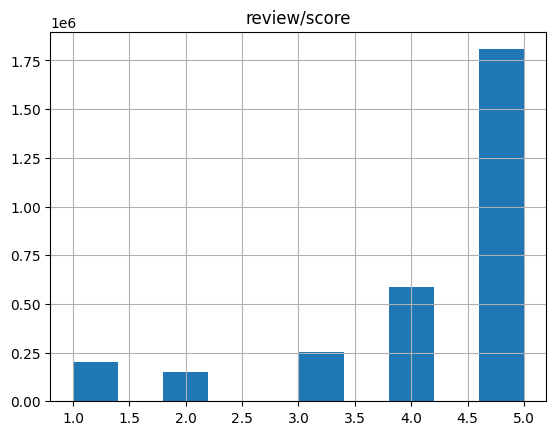

In [16]:
rating_df.hist('review/score')

## Books Dataset

In [17]:
books_df = pd.read_csv('01_Data/books_data.csv')
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


In [18]:
books_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [19]:
# Drop books with nan in image
# just for convenience with the show_image function later ;)

books_df.dropna(subset=['image'], inplace=True)
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160329 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          160328 non-null  object 
 1   description    136957 non-null  object 
 2   authors        155027 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    160329 non-null  object 
 5   publisher      130183 non-null  object 
 6   publishedDate  159405 non-null  object 
 7   infoLink       160329 non-null  object 
 8   categories     151884 non-null  object 
 9   ratingsCount   47127 non-null   float64
dtypes: float64(1), object(9)
memory usage: 13.5+ MB


# Collabroative Filtering mit SVD

In [20]:
# Merge the two dataframes by Title
df = pd.merge(rating_df, books_df, on='Title')

# Drop the Id column
df.drop('ratingsCount', axis=1, inplace=True) # seems to be wrong data

# Count numbers of reviews per book and add it to the dataframe
df['number_of_reviews'] = df.groupby('Title')['Title'].transform('count')

len(df)

2459694

In [21]:
# drop all books with less than 50 reviews

df = df[df['number_of_reviews'] >= 50]
len(df)

1509689

In [22]:
# drop unnecessary columns
df.drop('profileName', axis=1, inplace=True)
df.drop('review/time', axis=1, inplace=True)
df.drop('description', axis=1, inplace=True)
df.drop('authors', axis=1, inplace=True)
df.drop('previewLink', axis=1, inplace=True)
df.drop('publisher', axis=1, inplace=True)
df.drop('image', axis=1, inplace=True)
df.drop('publishedDate', axis=1, inplace=True)
df.drop('infoLink', axis=1, inplace=True)
df.drop('categories', axis=1, inplace=True)
#df.drop('ratingsCount', axis=1, inplace=True)

# rename the column
df.rename(columns={'review/score': 'rating'}, inplace=True)
df.rename(columns={'Id': 'book_id'}, inplace=True)
df.rename(columns={'Title': 'title'}, inplace=True)
df.rename(columns={'User_id': 'user_id'}, inplace=True)

df

,book_id,title,user_id,rating,number_of_reviews
360,0671551345,Night World: Daughters Of Darkness,ADB0JID2XRFYR,5.0,134.0
361,0671551345,Night World: Daughters Of Darkness,NaN,5.0,134.0
362,0671551345,Night World: Daughters Of Darkness,NaN,3.0,134.0
363,0671551345,Night World: Daughters Of Darkness,A1V0SFB3AXM8JK,1.0,134.0
364,0671551345,Night World: Daughters Of Darkness,NaN,5.0,134.0
...,...,...,...,...,...
2459395,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2E55F0514C3UG,1.0,96.0
2459396,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AUEN15WF0UAMJ,1.0,96.0
2459397,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,NaN,1.0,96.0
2459398,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AWF6YB8EKN2C6,2.0,96.0


In [23]:
# show all ratings from User AZZQLMNX239VT
df[df['user_id'] == 'AZZQLMNX239VT']

,book_id,title,user_id,rating,number_of_reviews
913204,B000P5ISWW,The Brothers Karamazov: A Modern Library Book ...,AZZQLMNX239VT,4.0,119.0
1103862,B000I364KE,Anna Karenina - translated from the Russian by...,AZZQLMNX239VT,5.0,505.0
1222166,B000MCJWZ0,Anna Karenina,AZZQLMNX239VT,5.0,850.0
2317819,B000GR6DWQ,The Brothers Karamazov (A Signet Classic CT33),AZZQLMNX239VT,4.0,120.0


In [24]:
# drop all reviews with NaN user_id just for convenience at the moment
df = df.dropna(subset=['user_id'])
df

,book_id,title,user_id,rating,number_of_reviews
360,0671551345,Night World: Daughters Of Darkness,ADB0JID2XRFYR,5.0,134.0
363,0671551345,Night World: Daughters Of Darkness,A1V0SFB3AXM8JK,1.0,134.0
366,0671551345,Night World: Daughters Of Darkness,AODBNCTX9L1L5,5.0,134.0
378,0671551345,Night World: Daughters Of Darkness,A107F528SN3XJU,5.0,134.0
380,0671551345,Night World: Daughters Of Darkness,AXYESYR1GNGM0,5.0,134.0
...,...,...,...,...,...
2459394,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2NNMPFZWPMT1L,5.0,96.0
2459395,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2E55F0514C3UG,1.0,96.0
2459396,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AUEN15WF0UAMJ,1.0,96.0
2459398,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AWF6YB8EKN2C6,2.0,96.0


In [25]:
# Count numbers of reviews per user and add it to the dataframe
df['number_of_reviews_user'] = df.groupby('user_id')['user_id'].transform('count')
df

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_28478/3449723507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_of_reviews_user'] = df.groupby('user_id')['user_id'].transform('count')


,book_id,title,user_id,rating,number_of_reviews,number_of_reviews_user
360,0671551345,Night World: Daughters Of Darkness,ADB0JID2XRFYR,5.0,134.0,1
363,0671551345,Night World: Daughters Of Darkness,A1V0SFB3AXM8JK,1.0,134.0,2
366,0671551345,Night World: Daughters Of Darkness,AODBNCTX9L1L5,5.0,134.0,1
378,0671551345,Night World: Daughters Of Darkness,A107F528SN3XJU,5.0,134.0,3
380,0671551345,Night World: Daughters Of Darkness,AXYESYR1GNGM0,5.0,134.0,2
...,...,...,...,...,...,...
2459394,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2NNMPFZWPMT1L,5.0,96.0,2
2459395,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2E55F0514C3UG,1.0,96.0,1
2459396,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AUEN15WF0UAMJ,1.0,96.0,1
2459398,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AWF6YB8EKN2C6,2.0,96.0,1


In [26]:
# Only use users with more than 5 reviews
df = df[df['number_of_reviews_user'] >= 5]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 599131 entries, 382 to 2459399
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   book_id                 599131 non-null  object 
 1   title                   599131 non-null  object 
 2   user_id                 599131 non-null  object 
 3   rating                  599131 non-null  float64
 4   number_of_reviews       599131 non-null  float64
 5   number_of_reviews_user  599131 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 32.0+ MB


In [27]:
# Drop Duplicates to create a Pivot Table
df.drop_duplicates(['user_id','title'], inplace=True)

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_28478/1674555218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['user_id','title'], inplace=True)


In [28]:
# Create Pivot Table
ratings = df.pivot(columns='title', index='user_id', values="rating")
# replace NaN with 0
ratings.fillna(0, inplace=True)
ratings


title,"""A"" IS FOR ALIBI","""C"" is for Corpse (A Kinsey Millhone mystery, Book 3)","""D"" is for Deadbeat","""Hey, Whipple, Squeeze This"": A Guide to Creating Great Ads (Adweek Magazine Series)","""Stand back,"" said the elephant, ""I'm going to sneeze!""","""Why Should White Guys Have All the Fun"": How Reginald Lewis Created a Billion-Dollar Business Empire","(ESV) English Standard Version Large Print Bible. Premium Bonded Leather, Black, Red Letter Text (English Language)","1,000 Places to See Before You Die: A Traveler's Life List","1,000 Vegetarian Recipes","1,000 Years, 1,000 People: Ranking the Men and Women Who Shaped the Millennium",...,"that quail, robert",the Enemy Within,the Picture of Dorian Gray,the Sword and the Stone,the art Spirit,the great brain,the heart of a dog,the lion's paw,the story of ferdinand,ttyl
user_id,,,,,,,,,,,,,,,,,,,,,
A00540411RKGTDNU543WS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00878773S2MNB00COHKV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00891092QIVH4W1YP46A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01038432MVI9JXYTTK5T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01254073JW8SSTKH6AIB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZEEEPUSM034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZHSA4KMGXG7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZK8T7V8NQ9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Create a copy of the DataFrame for the predicted Ratings
predicted_ratings = ratings.copy()

In [30]:
# Create Sparse Matrix
sparse_ratings = csr_matrix(ratings.values)

In [31]:
# Use ALS with 10 factors
als_model = implicit.als.AlternatingLeastSquares(factors=10)

# Fit the model on the transposed sparse_ratings matrix
als_model.fit(sparse_ratings.T) 

# predict ratings for all users
predicted_ratings = np.dot(als_model.user_factors, als_model.item_factors.T)


/Users/flaviopfister/anaconda3/envs/rs/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 10 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/Users/flaviopfister/anaconda3/envs/rs/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0017840862274169922 seconds
  warnings.warn(
100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


In [36]:
# Check Shape and Transpose it back
predicted_ratings.shape 
predicted_ratings = predicted_ratings.T
predicted_ratings.shape

(50375, 7071)

In [37]:
predicted_ratings

array([[ 0.00114086,  0.00067796, -0.00049264, ..., -0.0004091 ,
         0.00387007,  0.00110589],
       [ 0.00114087,  0.00067797, -0.00049264, ..., -0.0004091 ,
         0.00387007,  0.00110589],
       [ 0.00181673,  0.00345925,  0.00516224, ...,  0.00011187,
        -0.00174142,  0.00133042],
       ...,
       [ 0.00114087,  0.00067796, -0.00049264, ..., -0.0004091 ,
         0.00387007,  0.00110589],
       [ 0.00244509,  0.00712574,  0.00485593, ..., -0.00016725,
         0.00284015,  0.00114667],
       [ 0.01063298,  0.0077084 ,  0.00637424, ...,  0.00034447,
         0.00366017,  0.00137128]], dtype=float32)

In [38]:
# create a pivot dataframe from the predicted ratings with the same columns and index as the original ratings dataframe
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=ratings.columns, index=ratings.index)

predicted_ratings_df

title,"""A"" IS FOR ALIBI","""C"" is for Corpse (A Kinsey Millhone mystery, Book 3)","""D"" is for Deadbeat","""Hey, Whipple, Squeeze This"": A Guide to Creating Great Ads (Adweek Magazine Series)","""Stand back,"" said the elephant, ""I'm going to sneeze!""","""Why Should White Guys Have All the Fun"": How Reginald Lewis Created a Billion-Dollar Business Empire","(ESV) English Standard Version Large Print Bible. Premium Bonded Leather, Black, Red Letter Text (English Language)","1,000 Places to See Before You Die: A Traveler's Life List","1,000 Vegetarian Recipes","1,000 Years, 1,000 People: Ranking the Men and Women Who Shaped the Millennium",...,"that quail, robert",the Enemy Within,the Picture of Dorian Gray,the Sword and the Stone,the art Spirit,the great brain,the heart of a dog,the lion's paw,the story of ferdinand,ttyl
user_id,,,,,,,,,,,,,,,,,,,,,
A00540411RKGTDNU543WS,0.001141,0.000678,-0.000493,-0.001062,0.000392,-0.000126,0.000213,-0.004383,-0.000014,-0.000025,...,-0.000731,0.000175,0.077059,0.002818,0.000013,0.004469,-0.001655,-0.000409,0.003870,0.001106
A00878773S2MNB00COHKV,0.001141,0.000678,-0.000493,-0.001062,0.000392,-0.000126,0.000213,-0.004383,-0.000014,-0.000025,...,-0.000731,0.000175,0.077059,0.002818,0.000013,0.004469,-0.001655,-0.000409,0.003870,0.001106
A00891092QIVH4W1YP46A,0.001817,0.003459,0.005162,0.000125,0.002399,-0.000386,0.000255,0.000810,0.000017,-0.000016,...,0.001219,-0.000848,-0.004476,0.002065,0.001914,-0.001708,0.001519,0.000112,-0.001741,0.001330
A01038432MVI9JXYTTK5T,0.009446,0.007918,0.006844,0.000165,0.002394,-0.000745,-0.000441,0.005080,0.000012,0.000055,...,0.002293,0.000313,0.469934,0.017443,-0.000527,0.008999,0.004449,0.000346,0.002724,0.000033
A01254073JW8SSTKH6AIB,0.002861,0.005461,0.008155,0.000198,0.003792,-0.000610,0.000404,0.001276,0.000027,-0.000025,...,0.001927,-0.001341,-0.007166,0.003261,0.003026,-0.002702,0.002402,0.000177,-0.002758,0.002102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZEEEPUSM034,-0.008304,-0.004157,-0.003976,0.001930,-0.000643,-0.000666,0.001089,-0.000416,-0.000002,-0.000005,...,0.001107,-0.002317,-0.084683,-0.005328,0.003138,0.000712,0.007861,0.000029,-0.001731,-0.002713
AZZHSA4KMGXG7,0.006024,0.004431,0.003686,0.000609,0.000746,0.000295,0.000377,0.005906,0.000015,0.000011,...,0.000628,0.000491,0.003403,0.001348,0.001060,0.000724,0.002457,0.000215,0.002663,0.000846
AZZK8T7V8NQ9N,0.001141,0.000678,-0.000493,-0.001062,0.000392,-0.000126,0.000213,-0.004383,-0.000014,-0.000025,...,-0.000731,0.000175,0.077059,0.002818,0.000013,0.004469,-0.001655,-0.000409,0.003870,0.001106


## Collaborativ with Surprise Package

In [32]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from surprise import accuracy

In [38]:
# only use the columns book_id, user_id and rating
df_surprise = df[['book_id', 'user_id', 'rating']]
df_surprise

,book_id,user_id,rating
382,0671551345,A2KBHSK5BS35BH,1.0
383,0671551345,AAGXEK8SQP7FB,5.0
414,0671551345,AZRCQEVXXL78E,4.0
415,0671551345,A31HGIGKNKCC2C,4.0
419,0671551345,A2WZON0QPX7C9X,5.0
...,...,...,...
2459374,B000HOMU48,A3P61OHXDKDQ7W,1.0
2459377,B000HOMU48,A2FOT0QE23VN6J,1.0
2459381,B000HOMU48,A3PSGJREO570YX,1.0
2459387,B000HOMU48,A3FCJWWZHV2FJH,1.0


### mit SVD

In [58]:
reader = Reader(rating_scale=(1, 5))

# Laden der Daten in ein Surprise-Dataset
data = Dataset.load_from_df(df[['user_id', 'book_id', 'rating']], reader)

# Initialisierung des SVD-Modells
algo = SVD()

# Führen einer 5-fachen Kreuzvalidierung durch
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Trainieren des Modells mit dem gesamten Datensatz
trainset = data.build_full_trainset()
algo.fit(trainset)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7753  0.7815  0.7728  0.7718  0.7732  0.7749  0.0035  
MAE (testset)     0.5369  0.5421  0.5359  0.5335  0.5345  0.5366  0.0030  
Fit time          2.79    2.68    2.82    2.83    2.87    2.80    0.06    
Test time         0.24    0.25    0.21    0.24    0.22    0.23    0.01    


In [39]:
# Source: https://github.com/leammurphy/books-rs/blob/main/book_RS.ipynb

# Take a subset of the df so it runs faster, you might have to take an even smaller subset
subset = df_surprise.sample(n=10000, random_state=187)

# Define the reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the merged dataframe into Surprise's Dataset object
data = Dataset.load_from_df(subset[['user_id', 'book_id', 'rating']], reader)

# Split the dataset
trainset, testset = train_test_split(data, test_size=0.2)

# Instantiate the algorithm
algo = SVD()

# Train the model
algo.fit(trainset)

In [42]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [43]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)
top_n

# gibt pro User die Top 10 Bücher mit ID und Rating aus

defaultdict(list,
            {'ADYRXZ22U5QEJ': [('B000NYRZ42', 4.962119390245411),
              ('B000JJVHZE', 4.935050263784618),
              ('B000L4056E', 4.92447203745181),
              ('B000Q032UY', 4.8938912269146195),
              ('B000NDSX6C', 4.891380573046559),
              ('B0008C546U', 4.884720136111188),
              ('0582528259', 4.829825124234227),
              ('B0006CZLYW', 4.807975644709473),
              ('B0006DXUU8', 4.788657446930548),
              ('B000NNOTXI', 4.778142629902638)],
             'A1NUNET0L0BFR4': [('B000NYRZ42', 4.925697599086356),
              ('B000NDSX6C', 4.916199452057696),
              ('B0006DXUU8', 4.833884616199021),
              ('0743477375', 4.791778445456328),
              ('B000JJVHZE', 4.779203161304971),
              ('B000J1OR0Y', 4.762343671324091),
              ('0582528259', 4.76123567192879),
              ('B000NWO8CG', 4.760621943333819),
              ('0762405414', 4.746953977299973),
              ('

In [57]:
rmse = accuracy.rmse(predictions)

RMSE: 0.2001


In [45]:
predictions[:5]

[Prediction(uid='ADYRXZ22U5QEJ', iid='0743249976', r_ui=4.2305, est=4.194696956393667, details={'was_impossible': False}),
 Prediction(uid='ADYRXZ22U5QEJ', iid='B000NQM9CI', r_ui=4.2305, est=4.263796963995776, details={'was_impossible': False}),
 Prediction(uid='ADYRXZ22U5QEJ', iid='B0006CZNCW', r_ui=4.2305, est=4.277764455555564, details={'was_impossible': False}),
 Prediction(uid='ADYRXZ22U5QEJ', iid='B000Q032UY', r_ui=4.2305, est=4.8938912269146195, details={'was_impossible': False}),
 Prediction(uid='ADYRXZ22U5QEJ', iid='B000GR0EZI', r_ui=4.2305, est=4.231542804743683, details={'was_impossible': False})]

In [52]:
# Map book_id to book title
id_to_title = dict(zip(df['book_id'], df['title']))

In [54]:
# Print the recommended items for each user
for uid, user_ratings in list(top_n.items())[:5]:
    print(uid, [iid for (iid, _) in user_ratings])

ADYRXZ22U5QEJ ['B000NYRZ42', 'B000JJVHZE', 'B000L4056E', 'B000Q032UY', 'B000NDSX6C', 'B0008C546U', '0582528259', 'B0006CZLYW', 'B0006DXUU8', 'B000NNOTXI']
A1NUNET0L0BFR4 ['B000NYRZ42', 'B000NDSX6C', 'B0006DXUU8', '0743477375', 'B000JJVHZE', 'B000J1OR0Y', '0582528259', 'B000NWO8CG', '0762405414', 'B0002XH6S4']
A3B086LGMBTXEI ['B0008C546U', 'B0007HS5OY', 'B0006DXUU8', '0716631970', '0140817751', '0582528259', 'B000Q60ZIK', 'B000NDSX6C', 'B0008CXTHG', '158726398X']
A2UNOBCGU92K94 ['158726398X', 'B000JJVHZE', '0967460115', 'B000GROP62', 'B0007DRGI4', 'B000NYRZ42', '0582528259', 'B000GQK706', 'B000Q08CDQ', 'B000PIIMPW']
A2COQFW8G4LD94 ['B000GQK706', 'B0006DXUU8', '158726398X', '0141804459', 'B000J1OR0Y', 'B000K7WNQW', 'B000NNOTXI', 'B000L4056E', 'B000KS2NFC', 'B000PRXGLS']


In [55]:
# Print the recommended items and their rating estimations for 5 users
for uid, user_ratings in list(top_n.items())[:5]:
    print(f"Test subject {uid}, I have carefully considered your preferences. I believe you would like the following books:")
    for (iid, rating) in user_ratings:
        print("- {} (rating: {:.2f})".format(id_to_title[iid], rating))
    print()

Test subject ADYRXZ22U5QEJ, I have carefully considered your preferences. I believe you would like the following books:
- A CHRISTMAS CAROL, BEING A GHOST STORY OF CHRISTMAS (rating: 4.96)
- To Kill A Mockingbird (rating: 4.94)
- The Fellowship of the Ring (rating: 4.92)
- The Hobbit or There and Back Again (rating: 4.89)
- The Hobbit (rating: 4.89)
- The count of Monte Cristo (The novels of Alexandre Dumas) (rating: 4.88)
- Jane Eyre (Simple English) (rating: 4.83)
- Animal Farm & 1984 (Collected Stories of the World's Greatest Writers) (rating: 4.81)
- A Christmas carol: In prose (rating: 4.79)
- To Kill a Mocking Bird (rating: 4.78)

Test subject A1NUNET0L0BFR4, I have carefully considered your preferences. I believe you would like the following books:
- A CHRISTMAS CAROL, BEING A GHOST STORY OF CHRISTMAS (rating: 4.93)
- The Hobbit (rating: 4.92)
- A Christmas carol: In prose (rating: 4.83)
- A Christmas Carol (Enriched Classics (Pocket)) (rating: 4.79)
- To Kill A Mockingbird (rat

In [45]:
# Function to get the top books for a user

def get_top_books_for_user(user_id, predicted_ratings_df, num_books=5):
    """
    Diese Funktion gibt die Top-Bücher für einen bestimmten Benutzer basierend auf den Vorhersagen zurück.
    
    :param user_id: Die Benutzer-ID für den Benutzer, für den Empfehlungen erstellt werden sollen.
    :param predicted_ratings_df: Der DataFrame mit den Vorhersagen (Benutzer x Bücher).
    :param num_books: Die Anzahl der Empfehlungen, die zurückgegeben werden sollen (Standardmäßig 5).
    :return: Eine Liste der Top-Bücher für den Benutzer.
    """
    user_ratings = predicted_ratings_df.loc[user_id]
    
    # Sorting all ratings
    sorted_books = user_ratings.sort_values(ascending=False)
    
    # takes the top n books
    top_books = sorted_books.head(num_books).index.tolist()
    return top_books


#print(f"Empfehlungen für Benutzer {user_id}: {recommendations}")

In [46]:
# Function to get the links to the books given as parameter

def get_book_links(book_ids):
    """
    Diese Funktion gibt die Links zu den Büchern zurück.
    
    :param book_ids: Die Buch-IDs für die Links zurückgegeben werden sollen.
    :return: Eine Liste der Links zu den Büchern.
    """
    links = []
    for book_id in book_ids:
        links.append(books_df[books_df['Title'] == book_id]['image'].values[0])
    return links

In [47]:
# Function to display the images of the books 

# may need to be reworked!!

def display_books_in_row(titles, urls):
    images = [Image(url=url, width=150, height=190) for url in urls]
    display(HTML("<div>" + "".join([f"<div style='display:inline-block; padding:10px; text-align:center;'>{image._repr_html_()}<br>{title}</div>" for image, title in zip(images, titles)]) + "</div>"))    


In [48]:
# Function to get a random user
# for testing purposes

def get_random_user_id():
    """
    Diese Funktion gibt eine zufällige Benutzer-ID zurück.
    
    :return: Eine zufällige Benutzer-ID.
    """
    return ratings.sample().index[0]


## Test User

In [52]:
# Test

user = get_random_user_id()
books = get_top_books_for_user(user, predicted_ratings_df, num_books=5)
urls = get_book_links(books)
display_books_in_row(books, urls)

In [53]:
# Check predited ratings for a specific user

user_ratings = predicted_ratings_df.loc[user] 
sorted_books = user_ratings.sort_values(ascending=False)

sorted_books

title
Nineteen Eighty-four                                          0.501442
1984                                                          0.501442
George Orwell 1984                                            0.499601
Brave New World                                               0.497990
Brave new world,: A novel                                     0.497629
                                                                ...   
Little Women                                                 -0.188452
Little Women (Courage giant classics)                        -0.188452
A tree grows in Brooklyn: A novel (Armed Services edition)   -0.227691
A Tree Grows in Brooklyn by Smith, Betty                     -0.227691
A Tree Grows in Brooklyn                                     -0.227691
Name: AR0OORCOS2MAI, Length: 7071, dtype: float32

# Content Based Filtering

> Vectorize descripton of the books and use it for calculating the similarity between the books

In [57]:
# get description of the book with index 1
books_df.loc[3, 'description']

'Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him with a passion that is forbidden by the church. Heath Sparks is a man of God who is busy taking care of his quadriplegic wife who was seriously injured in a sever car accident. In an innocent effort to reach out to a lonely member of his church, Heath finds himself as the man and not the minister as Heath and Julia surrender their bodies to each other and face the wrath of God. Julia finds herself in over her head as she faces a deadly disease, the loss of her home and whispers about her wicked affair. Julia leaves the states offering her body as a living sacrifice in hopes of finding a cure while her heart remains thousands of miles away hoping to one day reunite with the man who holds it hostage.Whispers of the Wicked Saints is a once in a lifetime romance that is breath taking, defying all the rules of romance an

In [58]:
# Drop all rows with NaN values in the description column
# Word2Vec Tokenizer hat Probleme mit NaN Values

books_df = books_df.dropna(subset=['description'])
books_df

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],http://books.google.com/books/content?id=lmLqA...,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,Tan Books & Pub,2009-01-01,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,['Biography & Autobiography'],NaN
...,...,...,...,...,...,...,...,...,...,...
212398,Autodesk Inventor 10 Essentials Plus,Autodesk Inventor 2017 Essentials Plus provide...,"['Daniel Banach', 'Travis Jones']",http://books.google.com/books/content?id=zxHRC...,http://books.google.com/books?id=zxHRCwAAQBAJ&...,SDC Publications,2016-03,https://play.google.com/store/books/details?id...,['Computers'],NaN
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,['Juvenile Fiction'],2.0
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,NaN,http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,NaN,1995,http://books.google.com/books?id=3n8k6wl4BbYC&...,['Juvenile Fiction'],NaN
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,Vintage,2003-08-12,https://play.google.com/store/books/details?id...,['Fiction'],19.0


In [64]:
# check how many Nan values in the description column
books_df.description.isna().sum()

0

In [65]:
# fraction of Nan values in the description column
books_df.description.isna().sum() / len(books_df)


0.0

# Embedding mit Roberta

In [54]:
from transformers import AutoTokenizer, TFRobertaModel
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = TFRobertaModel.from_pretrained("roberta-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = model(inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [66]:
last_hidden_states.shape

TensorShape([1, 8, 768])

# Embedding mit Doc2Vec

In [67]:
books_df.head(4)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0


In [68]:
# Prepare Data for Word2Vec

tagged_data = [TaggedDocument(words=word_tokenize(text.lower()), tags=[str(i)]) for i, text in enumerate(books_df['description'])]

In [69]:
# Train the Word2Vec Model

model = Doc2Vec(vector_size=250, window=5, min_count=1, epochs=10)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [70]:
# just for testing purposes

text_to_embed = 'Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him with a passion that is forbidden by the church. Heath Sparks is a man of God who is busy taking care of his quadriplegic wife who was seriously injured in a sever car accident. In an innocent effort to reach out to a lonely member of his church, Heath finds himself as the man and not the minister as Heath and Julia surrender their bodies to each other and face the wrath of God. Julia finds herself in over her head as she faces a deadly disease, the loss of her home and whispers about her wicked affair. Julia leaves the states offering her body as a living sacrifice in hopes of finding a cure while her heart remains thousands of miles away hoping to one day reunite with the man who holds it hostage.Whispers of the Wicked Saints is a once in a lifetime romance that is breath taking, defying all the rules of romance and bending the laws of love.'
embeddings = model.infer_vector(word_tokenize(text_to_embed.lower()))

In [71]:
# Shape of the Embeddings

embeddings.shape

(250,)

In [72]:
# Calculate the similarity between the embeddings and the documents in the model
# uses Test-Embedding from manual input

similar_documents = model.docvecs.most_similar(positive=[embeddings])

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_92616/1438082980.py:4: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_documents = model.docvecs.most_similar(positive=[embeddings])


In [73]:
# Check results

similar_documents

[('2', 0.8339560627937317),
 ('10197', 0.5663159489631653),
 ('105902', 0.5215837359428406),
 ('97203', 0.5134956240653992),
 ('69482', 0.5117202997207642),
 ('81420', 0.5093767046928406),
 ('48985', 0.5089392066001892),
 ('23586', 0.5079100131988525),
 ('48505', 0.5071102976799011),
 ('37169', 0.5042781233787537)]

In [75]:
# berechne Embeddings für alle Bücher und speichere sie als Liste in der Spalte 'embeddings'
books_df['embeddings'] = books_df['description'].apply(lambda x: model.infer_vector(word_tokenize(x.lower())))
books_df.head(4)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,embeddings
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,"[-0.17830664, -0.06724536, -0.033768427, 0.024..."
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,"[-0.07342331, -0.03741641, -0.17169109, -0.042..."
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,"[-0.41574353, -0.041447777, -0.29338163, 0.292..."
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,"[0.13385248, 0.13886231, 0.10494283, -0.128222..."


In [21]:
# save the dataframe as csv
books_df.to_csv('01_Data/books_data_embeddings.csv', index=False)


In [22]:
# load the dataframe
new_df = pd.read_csv('01_Data/books_data_embeddings.csv')
new_df.head(4)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,embeddings
0,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,[-0.07961161 0.03540632 0.02624479 -0.144790...
1,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,[-0.02649175 -0.09063662 0.07062624 0.024100...
2,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,[ 0.1185066 0.32673895 0.31888542 0.437906...
3,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,[ 0.05028091 0.2058532 0.04828251 0.116049...


In [74]:
# Needs to be changed!
# Problem with saving a coma separeted python list as a csv ;)
